In [1]:
%pip uninstall -y unsloth

Found existing installation: unsloth 2024.11.5
Uninstalling unsloth-2024.11.5:
  Successfully uninstalled unsloth-2024.11.5
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install unsloth

  Using cached unsloth-2024.11.5-py3-none-any.whl.metadata (59 kB)
Using cached unsloth-2024.11.5-py3-none-any.whl (161 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [5]:
import torch
from trl import SFTTrainer
from transformers import TrainingArguments, TextStreamer
from unsloth.chat_templates import get_chat_template
from unsloth import FastLanguageModel
from datasets import Dataset
from unsloth import is_bfloat16_supported

# Saving model
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

/anaconda/envs/azureml_py38_PT_TF/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-10 08:28:47.998211: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-10 08:28:48.930386: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-10 08:28:49.200679: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-10 08:28:51.312565: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow 

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


In [6]:
old_data = pd.read_json("hf://datasets/Amod/mental_health_counseling_conversations/combined_dataset.json", lines=True)

print("old_data", old_data)

old_data                                                 Context  \
0     I'm going through some things with my feelings...   
1     I'm going through some things with my feelings...   
2     I'm going through some things with my feelings...   
3     I'm going through some things with my feelings...   
4     I'm going through some things with my feelings...   
...                                                 ...   
3507  My grandson's step-mother sends him to school ...   
3508  My boyfriend is in recovery from drug addictio...   
3509  The birth mother attempted suicide several tim...   
3510  I think adult life is making him depressed and...   
3511  I just took a job that requires me to travel f...   

                                               Response  
0     If everyone thinks you're worthless, then mayb...  
1     Hello, and thank you for your question and see...  
2     First thing I'd suggest is getting the sleep y...  
3     Therapy is essential for those that are feel

In [7]:

raw_data = pd.read_parquet("hf://datasets/qiaojin/PubMedQA/pqa_artificial/train-00000-of-00001.parquet")

In [8]:
import pandas as pd
import json
import ast

def transform_pubmed_to_counseling_format(df):
    """
    Transform PubMedQA dataset format to match the mental health counseling dataset format.
    Properly handles array-like context structures.
    """
    transformed_data = []
    
    for _, row in df.iterrows():
        try:
            
            row["Context"] = row["question"]
            row["Response"] = row["long_answer"]
            transformed_data.append(row)
            #print("row", row)
            """
            # Handle context extraction
            context_data = row['context']
            
            # If context is a string that looks like a dict, parse it
            if isinstance(context_data, str):
                try:
                    context_data = ast.literal_eval(context_data)
                except:
                    context_data = {'contexts': [context_data]}
            
            # Extract contexts array
            if isinstance(context_data, dict) and 'contexts' in context_data:
                contexts = context_data['contexts']
            else:
                contexts = []

            # Ensure contexts is a list of strings
            if isinstance(contexts, list):
                context_text = ' '.join(str(c) for c in contexts)
            else:
                context_text = str(contexts)
            
            # Create conversation format
            conversation = [
                {
                    "role": "user",
                    "content": str(row['question'])
                },
                {
                    "role": "assistant",
                    "content": str(row['long_answer'])
                }
            ]
            
            if context_text:
                conversation.insert(0, {
                    "role": "system",
                    "content": f"Context: {context_text}"
                })
            
            transformed_entry = {
                'id': str(row['pubid']),
                'conversation': conversation,
                'metadata': {
                    'source': 'PubMedQA',
                    'final_decision': str(row['final_decision'])
                }
            }
            
            transformed_data.append(transformed_entry)"""
            
        except Exception as e:
            print(f"Error processing row with pubid {row['pubid']}: {str(e)}")
            # Print additional debug info
            print(f"Context type: {type(row['context'])}")
            print(f"Context value: {row['context']}")
            continue
    
    # Convert to dataframe
    transformed_df = pd.DataFrame(transformed_data)
    return transformed_df

# Let's try processing just the first few rows to debug
#debug_df = data.head(1)
data = transform_pubmed_to_counseling_format(raw_data)

In [9]:
print("raw_data", raw_data)

raw_data            pubid                                           question  \
0       25429730  Are group 2 innate lymphoid cells ( ILC2s ) in...   
1       25433161  Does vagus nerve contribute to the development...   
2       25445714  Does psammaplin A induce Sirtuin 1-dependent a...   
3       25431941  Is methylation of the FGFR2 gene associated wi...   
4       25432519  Do tumor-infiltrating immune cell profiles and...   
...          ...                                                ...   
211264   8217974  Is urine production rate related to behavioura...   
211265   8204319  Does evaluation of the use of general practice...   
211266   8205673  Does intracoronary angiotensin-converting enzy...   
211267   8215873  Does transfusion significantly increase the ri...   
211268   8201088  Is low intramucosal pH associated with failure...   

                                                  context  \
0       {'contexts': ['Chronic rhinosinusitis (CRS) is...   
1       {'contex

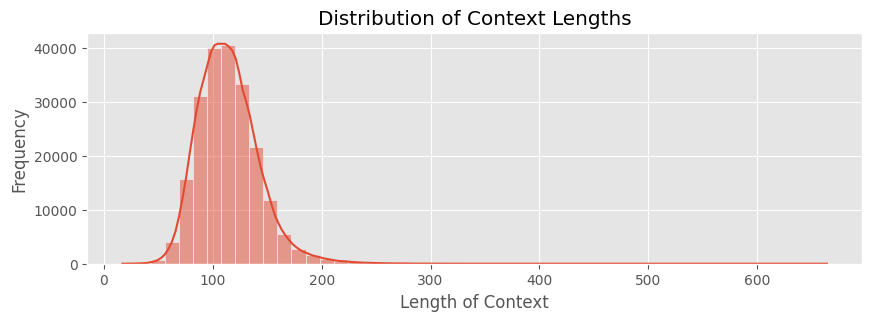

In [10]:
data['Context_length'] = data['Context'].apply(len)
plt.figure(figsize=(10, 3))
sns.histplot(data['Context_length'], bins=50, kde=True)
plt.title('Distribution of Context Lengths')
plt.xlabel('Length of Context')
plt.ylabel('Frequency')
plt.show()

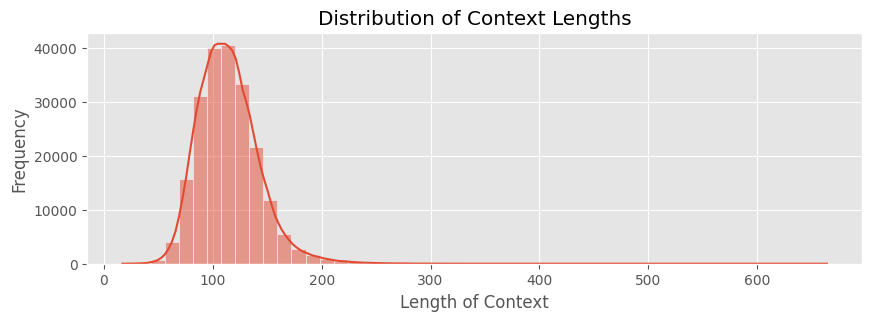

In [11]:
filtered_data = data[data['Context_length'] <= 1500]

ln_Context = filtered_data['Context'].apply(len)
plt.figure(figsize=(10, 3))
sns.histplot(ln_Context, bins=50, kde=True)
plt.title('Distribution of Context Lengths')
plt.xlabel('Length of Context')
plt.ylabel('Frequency')
plt.show()

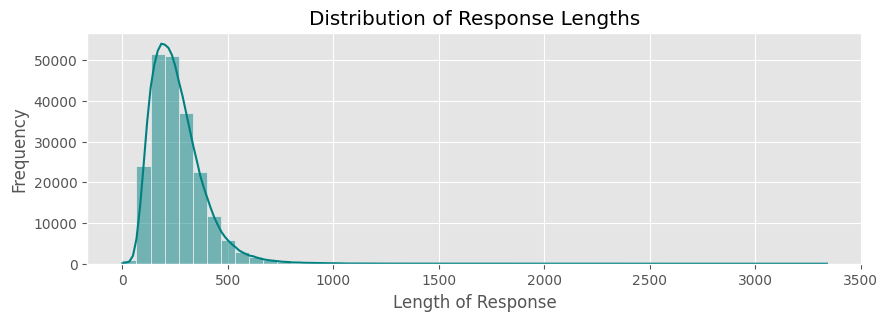

In [12]:
ln_Response = filtered_data['Response'].apply(len)
plt.figure(figsize=(10, 3))
sns.histplot(ln_Response, bins=50, kde=True, color='teal')
plt.title('Distribution of Response Lengths')
plt.xlabel('Length of Response')
plt.ylabel('Frequency')
plt.show()



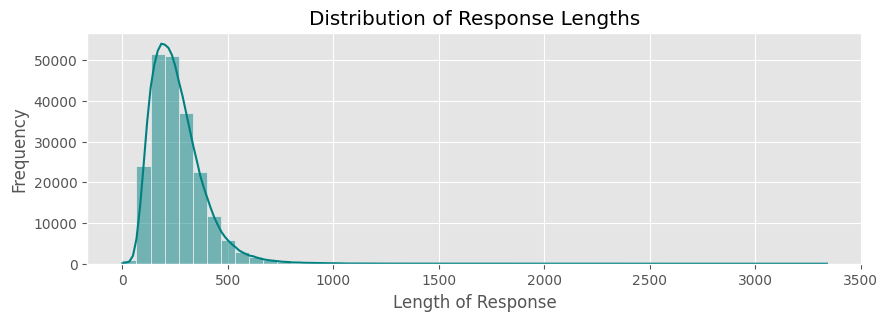

In [13]:
filtered_data = filtered_data[ln_Response <= 4000]

ln_Response = filtered_data['Response'].apply(len)
plt.figure(figsize=(10, 3))
sns.histplot(ln_Response, bins=50, kde=True, color='teal')
plt.title('Distribution of Response Lengths')
plt.xlabel('Length of Response')
plt.ylabel('Frequency')
plt.show()

In [14]:
max_seq_length = 5020
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/Llama-3.2-1B-bnb-4bit",
    max_seq_length=max_seq_length,
    load_in_4bit=True,
    dtype=None,
)

model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    lora_alpha=16,
    lora_dropout=0,
    target_modules=["q_proj", "k_proj", "v_proj", "up_proj", "down_proj", "o_proj", "gate_proj"],
    use_rslora=True,
    use_gradient_checkpointing="unsloth",
    random_state = 32,
    loftq_config = None,
)
print(model.print_trainable_parameters())

==((====))==  Unsloth 2024.11.5: Fast Llama patching. Transformers = 4.47.0.dev0.
   \\   /|    GPU: Tesla V100-PCIE-16GB. Max memory: 15.773 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.5.1+cu124. CUDA = 7.0. CUDA Toolkit = 12.4.
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2024.11.5 patched 16 layers with 16 QKV layers, 16 O layers and 16 MLP layers.


trainable params: 11,272,192 || all params: 1,247,086,592 || trainable%: 0.9039
None


In [15]:
data_prompt = """
### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token
def formatting_prompt(examples):
    inputs       = examples["Context"]
    outputs      = examples["Response"]
    texts = []
    for input_, output in zip(inputs, outputs):
        text = data_prompt.format(input_, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }

In [16]:
training_data = Dataset.from_pandas(filtered_data)
training_data = training_data.map(formatting_prompt, batched=True)



Map: 100%|██████████| 211269/211269 [00:01<00:00, 107704.29 examples/s]


In [17]:
%pip install mlflow

Note: you may need to restart the kernel to use updated packages.


In [18]:
%pip install --upgrade --no-cache-dir unsloth git+https://github.com/huggingface/transformers.git git+https://github.com/huggingface/trl.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-0n3vllvh
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-0n3vllvh
  Resolved https://github.com/huggingface/transformers.git to commit 768f3c016eec88a00f2a991c7017a8a5423c4b06
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/huggingface/trl.git to /tmp/pip-req-build-ebjlnefq
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/trl.git /tmp/pip-req-build-ebjlnefq
  Resolved https://github.com/huggingface/trl.git to commit c86b51cd12c413e3975be2a0e7285312ad36d0bf
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import torch
from transformers import TrainingArguments
from trl import SFTTrainer

# Memory optimizations
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
torch.cuda.empty_cache()

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=training_data,
    #dataset_text_field="text",
    #max_seq_length=max_seq_length,
    #dataset_num_proc=2,
    #packing=True,
    args=TrainingArguments(
        learning_rate=3e-4,
        lr_scheduler_type="linear",
        # Reduce batch size
        per_device_train_batch_size=2,  # Reduced from 16
        gradient_accumulation_steps=32,  # Increased from 8 to maintain effective batch size
        num_train_epochs=40,
        # Memory optimizations
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        gradient_checkpointing=True,  # Enable gradient checkpointing
        optim="adamw_8bit",
        logging_steps=1,
        weight_decay=0.01,
        warmup_steps=10,
        output_dir="output",
        seed=0,
        report_to=[],  # Disable logging to save memory
    ),
)

# Clear memory before training
if torch.cuda.is_available():
    torch.cuda.empty_cache()

trainer.train()

Map: 100%|██████████| 211269/211269 [00:16<00:00, 12562.41 examples/s]
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 211,269 | Num Epochs = 40
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 32
\        /    Total batch size = 64 | Total steps = 132,040
 "-____-"     Number of trainable parameters = 11,272,192


Step,Training Loss
1,0.093600
2,0.093100
3,0.089300
4,0.085500
5,0.077800
6,0.073400
7,0.072700
8,0.067600
9,0.066800
10,0.069800
